Traitement de données massives avec Pyspark
========
Introduction à PySpark 
--------
- - - -

__Apache Spark__ est un framework open-source de calcul distribué qui permet de traiter des bases de données de taille massive. Ceci est permis grâce à une distribution de données intelligente où les calculs sont effectués en parallèle sur plusieurs clusters, travaillant chacun sur une partie des données.

Si vous avez des bases de données trop volumineuses entraînant des temps de calcul trop lents, il est judicieux d'utiliser __Apache Spark__.

__Spark__ est un framework optimisé pour le traitement de données et l'application d'algorithmes de Machine Learning. Cela est notamment possible grâce à des structures de données présentées dans ce module.

__Apache Spark__ a été développé par l'AMPLab de UC Berkeley. Il a été développé en __Scala__ et est au meilleur de ses capacités dans son langage natif. La librairie __PySpark__ propose d'utiliser Spark avec le langage Python où dans de nombreux cas d'usages les performances sont similaires à des implémentations avec __Scala__.

Au cours de cette formation, nous allons :
* Présenter les différents éléments centraux de Spark, en commençant par les RDD, la structure la plus élémentaire de Spark qui permet d'effectuer des tâches très variées.
* Comprendre le fonctionnement sous-jacent de Spark.
* Présenter le type DataFrame, une structure plus riche que les RDD, optimisée pour le Machine Learning. La structure DataFrame de Spark est très proche dans sa forme à celle du package pandas en Python. Les DataFrame de Spark offrent néanmoins une performance sans égale lorsqu'ils sont mis en place sur plusieurs clusters.
* Nous terminerons cette formation avec la construction d'un système de recommandation avec Spark qui sera une bonne base pour une mise en production.

Dans ce chapitre nous allons nous intéresser aux __Resilient Distributed Datasets__ (RDD).

Ce premier exercice a pour but de se familiariser avec les concepts de base de __Spark__ et plus généralement de la distribution de données. La structure RDD est la structure élémentaire de __Spark__, elle est souple et optimale en performance pour toute opération linéaire. Cette structure a cependant une performance limitée lorsqu'il s'agit d'opérations non linéaires, c'est pour cela que nous introduirons la structure DataFrame dans le chapitre suivant.

Tout au long de cette formation, nous travaillerons sur une base de données proposée par IBM que nous avons mise en forme (version originale disponible ici https://github.com/nraychaudhuri/ibm-spark-examples/tree/master/data/airline-flights/alaska-airlines) contenant tous les vols effectués par Alaska Airlines sur l'année 2008 ainsi que les informations relatives aux annulations et retards des différents vols.

## 1. Introduction au SparkContext

Avant de commencer à coder, il est important de comprendre les bases de fonctionnement de __Spark__. Toute fonction __Spark__ est appelée à partir d'un SparkContext.

SparkContext est l'objet qui gère les connexions avec le cluster Spark et coordonne les différents calculs sur les différents clusters. Un des très gros avantages de Spark réside dans le fait que nous ne pourrions définir le SparkContext qu'une seule fois, et que le code est totalement indépendant du SparkContext. Si nous travaillons sur un cluster de 8 machines par exemple, la distribution des calculs se fait par le biais du SparkContext, mais le reste du code reste identique. Il est donc possible de développer son code en local ou sur une machine quelconque. Pour envoyer le programme en production sur un cluster, il suffira de changer la définition du SparkContext. Par convention, sc désignera le SparkContext tout au long de la formation.

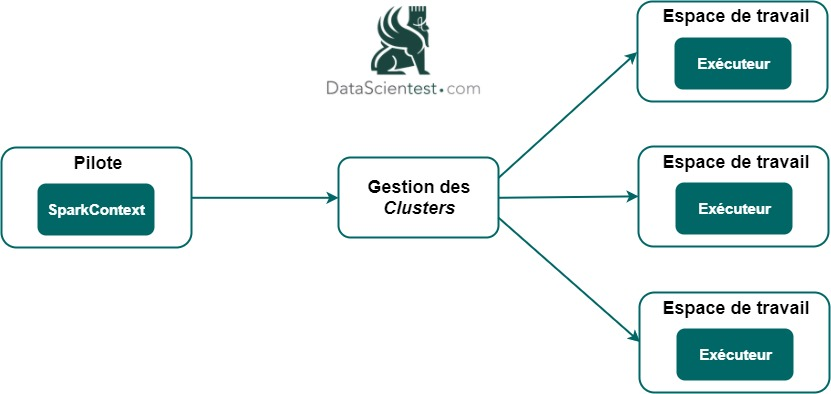

In [1]:
from IPython.display import display, IFrame, Image, HTML
image = Image(filename='img/clusters_overview.jpg', width=600)
display(image)

* (a) Exécuter la cellule ci-dessous pour importer SparkContext et définir un SparkContext local.

<div class="alert alert-danger" role="alert">
L'exécution deux fois successives de la cellule ci-dessous génère une erreur. En général, il est conseillé d'utiliser <code>SparkContext.getOrCreate()</code> qui récupère un contexte Spark s'il y en a un, ou le crée sinon.
</div>

In [2]:
# Import de SparkContext du module pyspark
from pyspark import SparkContext

# Définiton d'un SparkContext en local
sc = SparkContext('local')
sc

<SparkContext master=local appName=pyspark-shell>

Un RDD est la représentation Spark d'un tableau de données, c'est une collection d'éléments que l'on peut utiliser pour contenir des tuples, des dictionnaires, des listes, etc. La structure RDD ressemble à une liste Python mais elle est distribuée sur plusieurs clusters et sa vitesse d'exécution est optimisée pour l'ensemble des opérations linéaires.

Nous insistons sur l'avantage des programmes Spark à être identique pour travailler en local ou sur plusieurs clusters. Localement, Spark simule une distribution des calculs en divisant la mémoire de l'ordinateur sans qu'aucune modification du code soit nécessaire : il est possible de développer sur sa machine puis de mettre en production ce code sur un cluster en ne modifiant que le SparkContext.

La méthode <code>textFile</code> d'un <code>SparkContext</code> permet de charger un fichier CSV (ou un fichier compressé) dans un RDD. Cette fonction s'utilise ainsi :
```python
sc.textFile("path_to_file.ext")
```

* (b) Importer la base de données "2008_raw.csv" dans un RDD appelé raw_rdd

<div class="alert alert-info" role="alert">
La librairie <code>time</code> permet de mesurer le temps écoulé entre l'appel et le résultat d'une fonction. Ce module est très pratique en Big Data pour compre
</div>

In [13]:
# Import de la bibliothèque time et calcul du temps au début de l'exécution (t0)
from time import time
t0 = time()

#Lecture du fichier "2008_raw.csv"
raw_rdd = sc.textFile("data/2008_raw.csv")

# Calcul du temps de la lecture du fichier
t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 0.039 secondes


<div class="alert alert-info" role="alert">
Une caractéristique importante des RDD est leur <code>immutabilité</code>. Une fois créés, ils ne peuvent plus être modifiés. Il faudra donc créer un nouveau RDD chaque fois que l'on voudra le modifier: une opération à éviter au maximum pour préserver la mémoire de l'ordinateur ou du serveur. Ce caractère <code>immutable</code> est essentiel pour le fonctionnement du calcul distribué : il garantit qu'une fois le RDD distribué sur un cluster, aucune modification n'aura lieu sur une partie du RDD qui pourrait fausser les résultats finaux.
</div>

## 2. Évaluation Paresseuse

L'appel à la fonction a été exécuté en un temps bref. Cela est lié au second avantage de cette structure qui est leur capacité à évaluer le code de façon __paresseuse__ (lazy evaluation), c'est à dire reporter le lancement des calculs jusqu'à ce que ce soit absolument nécessaire.

Par exemple, lorsque la méthode sc.textFile a été appelée, seul un pointeur vers le fichier a été créé. Ce n'est qu'au dernier moment, lorsque l'on recherche à afficher ou utiliser un résultat, que le calcul est effectué.

Pour apercevoir le contenu d'un RDD, on doit utiliser des méthodes comme <code>take(n)</code> permet de retourner les n premiers éléments d'un RDD. Toutes les méthodes __PySpark__ sont ici très puissantes. En effet, __PySpark__ est une bibliothèque qui interface avec Python en cachant le langage __Scala__. Par exemple, la méthode <code>take</code> renvoie une liste __Python__ d'éléments mais est allée chercher cette information au sein d'un cluster __Spark__ codé en __Scala__.

La force de __PySpark__ réside dans l'exploitation des performances de l'architecture de __Spark__ sans coder une seule ligne de __Scala__.

* (a) Afficher les 5 premiers éléments de raw_rdd à l'aide de la méthode take.<br>
* (b) Mesurer le temps nécessaire à l'affichage de ces 5 éléments.

In [11]:
# Calcul du temps au début de l'exécution (t0)
t0 = time()

# Insérez votre code ici 
print(raw_rdd.take(5))

### Ne pas modifier le code ci-dessous
# Calcul du temps de l'affichage des 5 éléments
t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

['2008,1,1,2,2057,2052,2312,2258,AS,324,N306AS,135,126,112,14,5,SEA,SJC,697,7,16,0,,0,NA,NA,NA,NA,NA', '2008,1,1,2,703,715,958,951,AS,572,N302AS,175,156,144,7,-12,SEA,PSP,987,6,25,0,,0,NA,NA,NA,NA,NA', '2008,1,1,2,2011,1846,2248,2145,AS,511,N564AS,157,179,136,63,85,SAN,SEA,1050,7,14,0,,0,0,0,0,0,63', '2008,1,1,2,2301,2300,2354,2359,AS,376,N309AS,53,59,35,-5,1,SEA,GEG,224,5,13,0,,0,NA,NA,NA,NA,NA', '2008,1,1,2,1221,1221,1422,1438,AS,729,N317AS,181,197,164,-16,0,TUS,SEA,1216,6,11,0,,0,NA,NA,NA,NA,NA']
Réalisé en 0.289 secondes


<div class="alert alert-success" role="alert">
Le temps de calcul pour charger 5 lignes est donc plus grand que celui de la méthode textFile. En effet, textFile construit simplement un pointeur vers la donnée alors que take(5) calcule les résultats pour les 5 premières lignes. Vous êtes invité à faire varier le nombre de lignes pour tester le temps de calcul de votre ordinateur : testez avec 10, 100, 1000, etc.
</div>

<div class="alert alert-info" role="alert">
Vous pouvez remarquer que les colonnes d'un RDD ne sont pas "nommées". Les RDD sont extrêmement rapides pour le traitement des données en ligne mais ne possèdent pas de structure inhérente permettant de faire des traitements en colonne.
</div>

La méthode count qui permet de compter le nombre de lignes du RDD demande d'aller chercher les informations au sein du fichier CSV et donc demande un léger temps de calcul.

* (c) Utiliser la méthode count pour enregistrer dans une variable nommée count le nombre de lignes du RDD

In [15]:
# Calcul du temps au début de l'exécution (t0)
t0 = time()

# Insérez votre code ici
count = raw_rdd.count()

### Ne pas modifier le code ci-dessous
# Calcul du temps d'affichage du nombre de lignes du RDD
t1 = time() - t0
print("Nombre de lignes :", count)
print("Réalisé en {} secondes".format(round(t1,3)))

Nombre de lignes : 151102
Réalisé en 0.352 secondes


## 3. Map & Reduce

Un RDD lit un fichier ligne par ligne. Dans son format actuel, il permet d'afficher certaines lignes ou de compter le nombre de lignes. Chaque ligne est un simple string contenant l'ensemble des données séparées par des virgules. Il faut donc séparer chaque ligne en une liste d'éléments pour pouvoir les traiter séparément par la suite.

Pour effectuer des traitements sur les lignes d'un RDD, il est possible d'utiliser la méthode map qui prend en argument une fonction à appliquer sur chaque ligne. N'importe quelle fonction peut être mise en argument dans map, à partir du moment où elle prend une ligne en entrée et renvoie en sortie une ligne à stocker dans un nouveau RDD.

__Exemple__ :<br>
Renvoyer le 1er élément de chaque ligne
```python
raw_rdd.map(lambda line: line[0])
```
__Fonctions anonymes__ :<br>
Le mot clé <code>lambda</code> permet de créer une fonction en une seule ligne.<br>
Par exemple, il existe deux façons de créer la fonction fun : 
```python
def fun(x):
    return x[0]

fun = lambda x: x[0]
```

Cette écriture a l'avantage de pouvoir être écrite directement au sein du code, sans avoir besoin de créer la fonction fun pour l'utiliser.<br>
Le même résultat est obtenu en créant une fonction fun puis en l'appelant dans map : <code>raw_rdd.map(fun)</code>

* (a) Créer un RDD nommé airplane_rdd dont chaque ligne est la liste des éléments de la ligne correspondante de raw_rdd.<br>
* (b) Afficher la première ligne de ce nouveau RDD.

<div class="alert alert-info" role="alert">
La méthode <code>split</code> permet de transformer une chaîne de caractères en une liste. Par exemple, la fonction qui a une chaîne de caractère <code>line</code> associe la liste <code>line.split(",")</code> isole tous les éléments de la ligne originellement séparés par des virgules.
</div>

In [30]:
# Création d'un RDD dont les lignes sont la liste des éléments de raw_rdd 
airplane_rdd = raw_rdd.map(lambda line: line.split(","))

# Affichage de la première ligne du rdd
airplane_rdd.take(1)

[['2008',
  '1',
  '1',
  '2',
  '2057',
  '2052',
  '2312',
  '2258',
  'AS',
  '324',
  'N306AS',
  '135',
  '126',
  '112',
  '14',
  '5',
  'SEA',
  'SJC',
  '697',
  '7',
  '16',
  '0',
  '',
  '0',
  'NA',
  'NA',
  'NA',
  'NA',
  'NA']]

Les RDD fonctionnent très bien pour des opérations "ligne par ligne", c'est pour cela que les méthodes map et reduce sont extrêmement efficaces pour ces calculs. Appliquer successivement la méthode map puis la méthode reduceByKey permet de résumer intelligemment nos données.

Par exemple, pour construire un diagramme à barres du nombre de vols effectués par aéroport de départ (l'aéroport de départ est la 8ème variable), il faut procéder en plusieurs étapes :

* (c) Utiliser la méthode map pour regrouper les données dans un couple grâce à la fonction qui à line associe le couple (line[7], 1). Cela nous permet d'avoir pour chaque ligne :
    * Une clé correspondant à l'aéroport de départ
    * Une valeur égale à 1 (à additionner ultérieurement)

<div class="alert alert-info" role="alert">
<code>reduceByKey(f)</code> combine des couples ayant la même clé en leur appliquant une fonction <code>f</code>. Il est donc possible ici d'appliquer la fonction <code>f</code> qui à un couple <code>(x,y)</code> associe <code>x+y</code> de façon à additionner successivement toutes les valeurs et donc obtenir le nombre d'apparition de chaque clé.
</div>

* (d) Créer un RDD nommé hist_rdd, en appliquant à airplane_rdd la méthode map puis la méthode reduceByKey comme expliqué ci-dessus<br>
* (e) Afficher les 5 premières lignes de hist_rdd

In [38]:
# Création d'un nouveau RDD en résumant les lignes par aéroport de départ
hist_rdd = airplane_rdd.map(lambda x: (x[17], 1)).reduceByKey(lambda x,y: x+y)

# Affichage d'un 5 premières lignes 
hist_rdd.take(5)

[('SJC', 3109), ('PSP', 1755), ('SEA', 48126), ('GEG', 1704), ('PDX', 11259)]

<div class="alert alert-info" role="alert">
La méthode <code>collect</code> prend en entrée un RDD et renvoie une liste correspondante au contenu du RDD. Le résultat de cette fonction se traite donc comme une liste et ne possède plus les attributs d'un RDD. Il est notamment non distribué et ne bénéficie plus de l'architecture de Spark.
</div>

* (a) Créer puis afficher la liste hist à partir du RDD hist_rdd.

In [40]:
# Création d'une liste à partir d'un RDD
hist = hist_rdd.collect()

# Affichage de la liste 
print(hist)

[('SJC', 3109), ('PSP', 1755), ('SEA', 48126), ('GEG', 1704), ('PDX', 11259), ('DEN', 2221), ('TUS', 443), ('SAN', 3960), ('ANC', 15341), ('LAS', 4022), ('LAX', 7151), ('FAI', 4537), ('SNA', 4839), ('KTN', 2381), ('OAK', 3340), ('SIT', 1332), ('ONT', 1403), ('SFO', 5068), ('JNU', 4410), ('PHX', 3251), ('ORD', 1459), ('RNO', 112), ('BUR', 1450), ('LGB', 1072), ('BOI', 75), ('SMF', 2019), ('MIA', 366), ('MCO', 967), ('LIH', 366), ('WRG', 727), ('PSG', 727), ('DFW', 1085), ('CDV', 725), ('BET', 1035), ('OTZ', 1086), ('YAK', 725), ('OME', 1090), ('ADQ', 706), ('BRW', 728), ('SCC', 727), ('DCA', 1093), ('EWR', 731), ('BOS', 985), ('HNL', 602), ('ADK', 102), ('AKN', 116), ('DLG', 116), ('GST', 85), ('OGG', 195), ('MSP', 133), ('KOA', 45)]


## 5. Trier et filtrer un RDD 

Beaucoup d'aéroports sont présents dans la liste ce qui la rend peu lisible au premier coup d'œil. Il est donc intéressant de trier cette liste par rapport aux valeurs de chaque clé (i.e.le nombre de vol pour chaque aéroport).

Pour cela, il est possible d'utiliser la fonction sorted qui prend en paramètre :<br>
* list : la liste à trier.<br>
* key : la liste des éléments à utiliser par référence de tri.<br>
* reverse : un entier indiquant l'ordre du tri : croissant (reverse = 0) ou décroissant (reverse = 1).

__Exemple__ : Tri par ordre alphabétique sur le premier élément<br>
```python
sorted(hist_rdd.collect(), key=lambda x: x[0])
```

* (a) Afficher __hist_rdd__ ordonné de façon décroissante par rapport au nombre de vol par aéroport.

In [44]:
# Tri des données par ordre décroissant
sorted(hist, key= lambda x: x[1], reverse= 1)

[('SEA', 48126),
 ('ANC', 15341),
 ('PDX', 11259),
 ('LAX', 7151),
 ('SFO', 5068),
 ('SNA', 4839),
 ('FAI', 4537),
 ('JNU', 4410),
 ('LAS', 4022),
 ('SAN', 3960),
 ('OAK', 3340),
 ('PHX', 3251),
 ('SJC', 3109),
 ('KTN', 2381),
 ('DEN', 2221),
 ('SMF', 2019),
 ('PSP', 1755),
 ('GEG', 1704),
 ('ORD', 1459),
 ('BUR', 1450),
 ('ONT', 1403),
 ('SIT', 1332),
 ('DCA', 1093),
 ('OME', 1090),
 ('OTZ', 1086),
 ('DFW', 1085),
 ('LGB', 1072),
 ('BET', 1035),
 ('BOS', 985),
 ('MCO', 967),
 ('EWR', 731),
 ('BRW', 728),
 ('WRG', 727),
 ('PSG', 727),
 ('SCC', 727),
 ('CDV', 725),
 ('YAK', 725),
 ('ADQ', 706),
 ('HNL', 602),
 ('TUS', 443),
 ('MIA', 366),
 ('LIH', 366),
 ('OGG', 195),
 ('MSP', 133),
 ('AKN', 116),
 ('DLG', 116),
 ('RNO', 112),
 ('ADK', 102),
 ('GST', 85),
 ('BOI', 75),
 ('KOA', 45)]

D'après le tri, l'aéroport de Seattle est de loin l'aéroport le plus desservi.

Il est souvent intéressant de pouvoir filtrer nos données. En effet, les fichiers CSV possèdent un header contenant le nom de la variable qui va être interprétée comme une modalité. Il existe pour cela la méthode filter qui permet filtrer certaines lignes.

__Exemple__ : Modalité de la première colonne<br>
airport_rdd.filter(lambda x: x[0] == "year")

* (b) Afficher le nombre de vols annulés par ville d'origine. Pour cela :
    * Filtrer les vols annulés ( line[10] ) à l'aide de filter.
    * Effectuer un map et reduce pour compter le nombre d'occurrence par ville d'origine (line[8]).
    * Afficher les résultats.

In [45]:
# Calcul et affichage du nombre de vols annulés par ville d'origine
airplane_rdd \
    .filter(lambda x: x[10] == "1") \
    .map(lambda x: (x[8], 1)) \
    .reduceByKey(lambda x,y: x+y) \
    .collect()

[]

<div class="alert alert-success" role="alert">
Il est possible d'écrire le code en une seule ligne. L'utilisation du "\" permet de passer à la ligne entre chaque méthode. En effet, comme chaque méthode PySpark utilisée ici crée un nouvel objet, il est alors optimal d'effectuer toutes les opérations successivement. L'utilisation de "\" permet donc un code plus lisible. Par exemple : 
    rdd \
      .filter(fun1) \
      .map(fun2) \
      .reduceByKey(fun3) \
      .collect()
</div>

Une fois que toutes les opérations sont effectuées et terminées, il faut avoir le bon réflexe de fermer le SparkContext ouvert en début d'exercice. En effet, on ne peut pas avoir plus d'un contexte sur une machine et pour éviter les conflits à l'avenir, fermer son SparkContext permet de s'assurer que plus aucun programme ne tourne sur la machine. Pour cela il existe tout simplement la méthode stop sans paramètre.

* (c) Fermer sc, le SparkContext de l'exercice.

In [46]:
# Fermeture du SparkContext
sc.stop()